In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sb

root = os.path.dirname(os.getcwd())
exa_root = '/home/jorgemarpa/data/'

# Metadata

In [2]:
meta = np.load('%s/imgs/PPD/param_arr.npy' % (exa_root))
meta = pd.DataFrame(meta, columns=['m_dust', 'Rc', 'f_exp', 'H0', 
                                   'Rin', 'sd_exp', 'a_max', 'inc'])
meta.head()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
0,1.000000e-07,100.0,1.15,5.0,0.1,0.0,10.0,90.0
1,1.000000e-07,100.0,1.15,5.0,0.1,-0.5,10.0,90.0
2,1.000000e-07,100.0,1.15,5.0,0.1,-1.0,10.0,90.0
3,1.000000e-07,100.0,1.15,5.0,1.0,-0.5,10.0,90.0
4,1.000000e-07,100.0,1.15,5.0,1.0,-1.0,10.0,90.0


In [3]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36518 entries, 0 to 36517
Data columns (total 8 columns):
m_dust    36518 non-null float64
Rc        36518 non-null float64
f_exp     36518 non-null float64
H0        36518 non-null float64
Rin       36518 non-null float64
sd_exp    36518 non-null float64
a_max     36518 non-null float64
inc       36518 non-null float64
dtypes: float64(8)
memory usage: 2.2 MB


In [4]:
meta.describe()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
count,3.651800e+04,36518.000000,36518.000000,36518.000000,36518.000000,36518.000000,36518.000000,36518.000000
mean,4.687795e-04,141.561148,1.077674,14.604168,3.673851,-0.733200,1875.546854,82.290184
std,4.662241e-04,112.383466,0.165470,5.157389,4.458092,0.554319,3599.579642,7.053243
min,1.000000e-07,10.000000,0.850000,5.000000,0.100000,-1.500000,10.000000,52.692572
25%,1.000000e-04,30.000000,1.000000,10.000000,0.100000,-1.000000,10.000000,78.344277
50%,1.000000e-04,100.000000,1.150000,15.000000,1.000000,-0.500000,100.000000,84.202364
75%,1.000000e-03,300.000000,1.150000,20.000000,10.000000,0.000000,1000.000000,87.104894
max,1.000000e-03,300.000000,1.300000,20.000000,10.000000,0.000000,10000.000000,90.000000


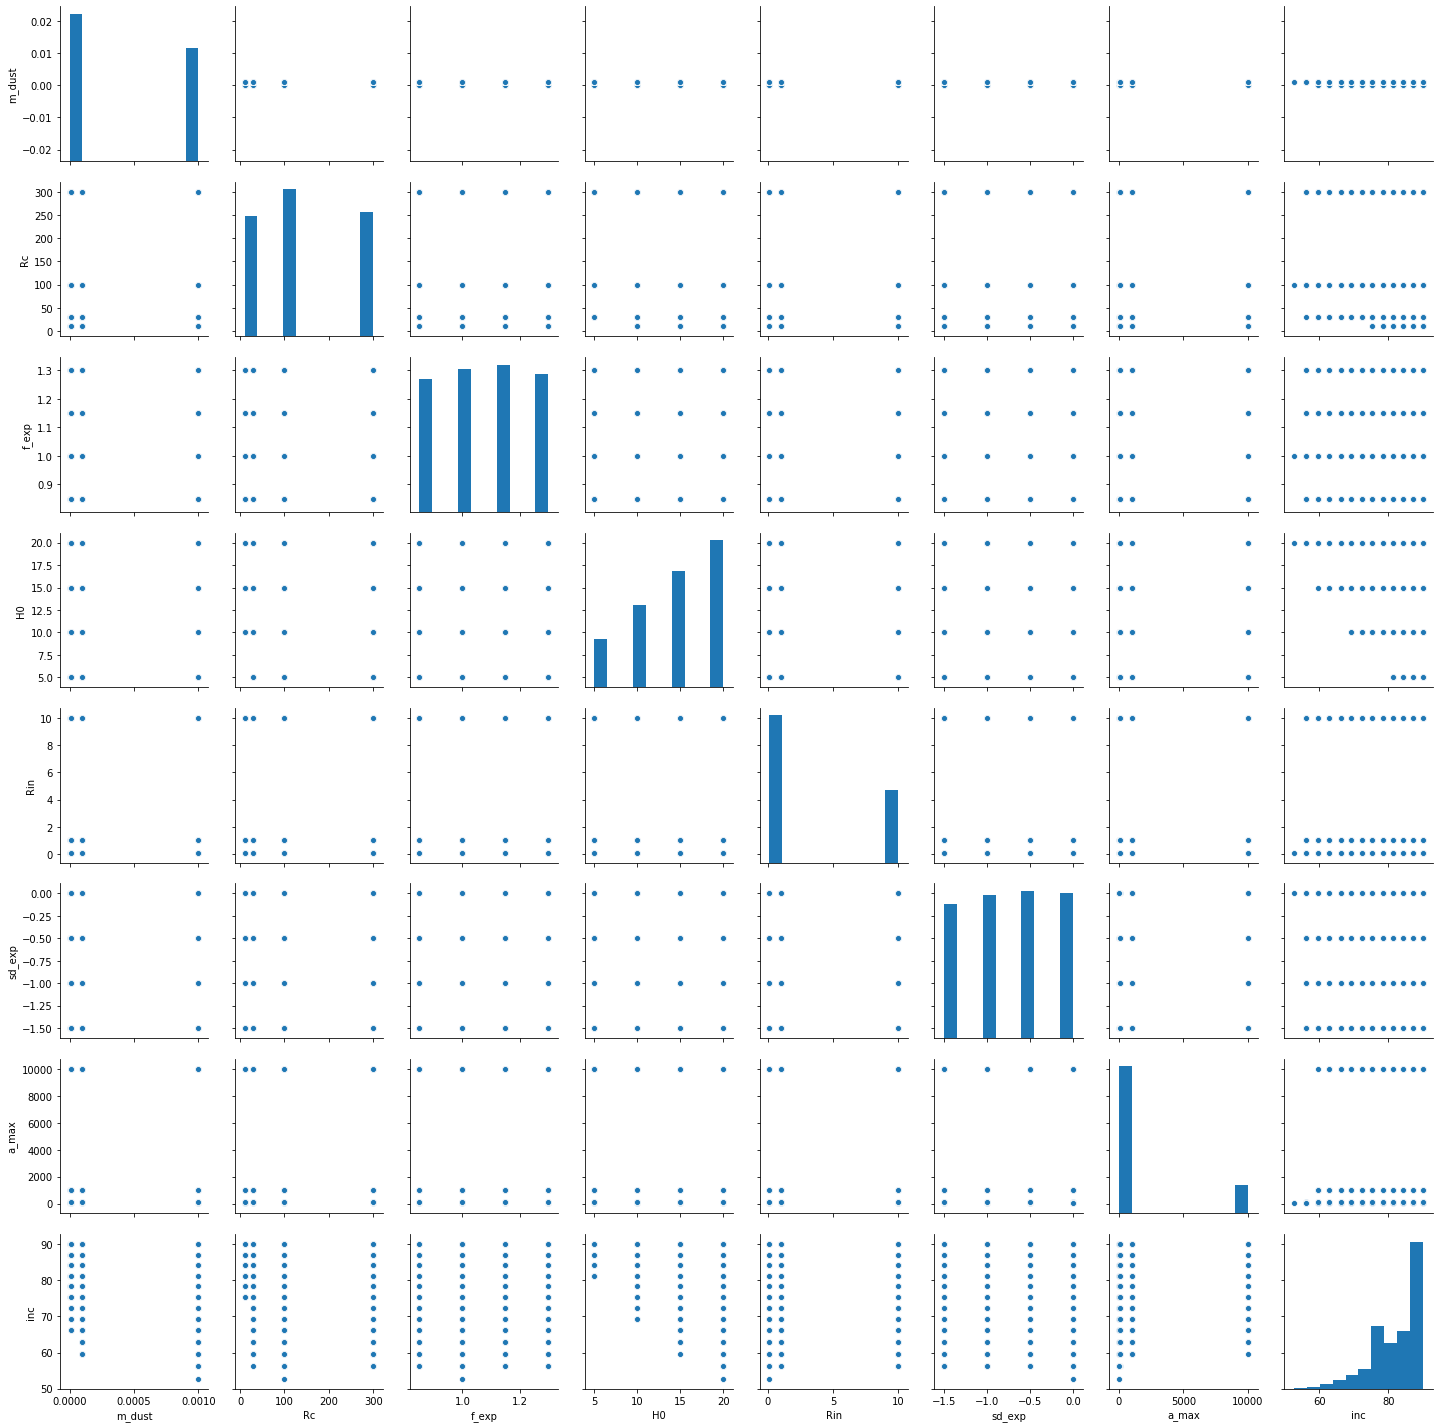

In [5]:
sb.pairplot(meta)
plt.show()

# Synthetic Images

In [6]:
imgs = np.load('%s/imgs/PPD/img_norm_array.npy' % (exa_root))
#imgs = np.expand_dims(imgs, axis=1)
imgs.shape

(36518, 1, 187, 187)

In [7]:
print('Min ', imgs.min(), 'Max ', imgs.max())
print('Mean ', imgs.mean(), 'Std ', imgs.std())

Min  0.0 Max  1.0
Mean  1.3716543e-05 Std  0.00047374613


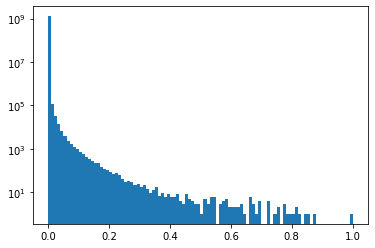

In [69]:
plt.hist(imgs.flatten(), bins=100, log=True)
plt.show()

In [85]:
def plot_wall(x):
    """Light-curves wall plot, function used during VAE training phase.
    Figure designed and ready to be appended to W&B logger.

    Parameters
    ----------
    xhat : numpy array
        Array of generated light curves
    x    : numpy array
        List of real light curves.
    epoch: int, optional
        Epoch number

    Returns
    -------
    fig
        a matplotlib figure
    image
        an image version of the figure
    """

    plt.close('all')
    ncols = 10
    v_min = np.min(x)
    v_max = np.max(x)
    norm = colors.SymLogNorm(linthresh=.0005, linscale=100,
                             vmin=v_min, vmax=v_max)
    print(v_min, v_max)
    fig, axis = plt.subplots(nrows=ncols, ncols=ncols, figsize=(ncols, ncols))
    for i, ax in enumerate(axis.ravel()):
        ax.imshow(x[i, 0, :, :], interpolation='bilinear',
                  cmap=cm.viridis, origin='upper', aspect='equal',
                  norm=norm)

    for ax in axis.ravel():
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)#, left=0, right=1)
    #plt.tight_layout()
    #fig.suptitle('Synthetic Images', fontsize=20, y=.95)
    plt.show()
    return

0.0 0.36106238


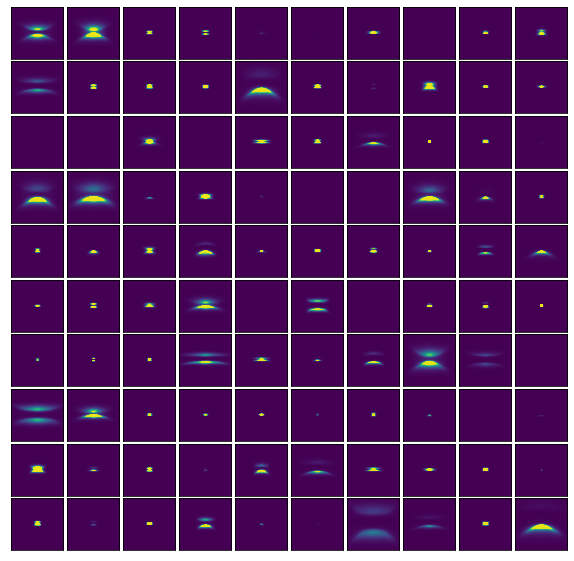

In [86]:
#idx = np.random.randint(0, imgs.shape[0], size=100)
plot_wall(imgs[idx])

In [17]:
meta.iloc[idx]

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
5991,0.000010,100.0,1.30,5.0,10.0,-0.5,1000.0,87.104894
12552,0.000100,100.0,0.85,10.0,10.0,-0.5,10.0,78.344277
36125,0.001000,300.0,1.30,20.0,0.1,-0.5,100.0,87.104894
27396,0.001000,100.0,1.00,10.0,1.0,-0.5,100.0,78.344277
2187,0.000010,30.0,0.85,20.0,0.1,-0.5,10.0,84.202364
19056,0.000100,300.0,1.15,10.0,10.0,-1.5,100.0,84.202364
33422,0.001000,300.0,1.00,20.0,0.1,-0.5,10.0,87.104894
27921,0.001000,100.0,1.00,15.0,10.0,-1.0,10.0,81.284810
23501,0.001000,30.0,1.15,5.0,1.0,-1.0,100.0,90.000000
25908,0.001000,100.0,0.85,5.0,10.0,-1.5,100.0,90.000000


In [46]:
big = meta.query('m_dust == 0.001 and Rc == 300 and f_exp == 1.3 and H0 == 20').index.values
print(meta.iloc[big].shape)
meta.iloc[big].tail()

(452, 8)


,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
36513,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,78.344277
36514,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,81.284810
36515,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,84.202364
36516,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,87.104894
36517,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,90.000000


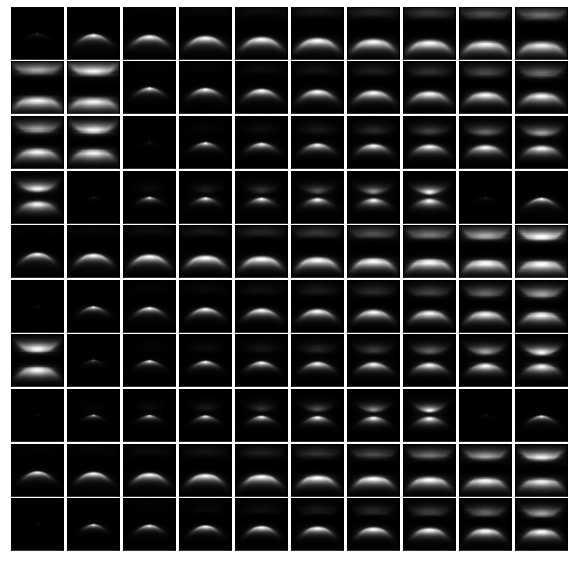

In [49]:
#plot_wall(imgs[np.random.choice(big, size=100, replace=False)])
plot_wall(imgs[big[:100]])